In [10]:
import sys
import pathlib as pl
sys.path.insert(0,str(pl.Path("../").absolute()))

In [11]:
from utils.data_loader import load_data

In [12]:
data_temp, data_wind = load_data()
display(data_temp.head(3))
display(data_wind.head(3))

,timestamp,differential_potential_CH1,differential_potential_CH2,transpiration
0,2022-01-22 13:53:42,526487,467544,442
1,2022-01-22 13:53:44,526542,467315,461
2,2022-01-22 13:53:45,526532,466868,466


,timestamp,differential_potential_CH1,differential_potential_CH2,transpiration
0,2022-01-22 13:53:37,505940,507749,621
1,2022-01-22 13:53:38,505846,507807,632
2,2022-01-22 13:53:40,505990,507764,629


In [13]:
import pandas as pd
data = data_temp.set_index("timestamp")
data = data["transpiration"][:30000]
q = data.quantile(0.1)
data = data[data > q]
data = pd.DataFrame(data)
data = data.reset_index()

In [14]:
import numpy as np
import pandas as pd
import numpy as np
import sklearn.preprocessing as skp
from tqdm import tqdm
from dataclasses import dataclass, asdict
from typing import *

@dataclass(frozen=True,slots=True)
class ExperimentData:
    data_resampled: pd.DataFrame
    scaler: skp.MinMaxScaler
    timefreq: str
    aggregator: str
    columns: list[str]
    window_size: int
    feature_size: int
    valid_windows: list[int]



def getExperimentData(data, timefreq, aggregator, columns, window_size, feature_size):
    data_resampled, scaler = scale_and_resample_timeindex(data, timefreq=timefreq, aggregator=aggregator)
    data_resampled = data_resampled[columns]
    data_resampled = data_resampled.reset_index()
    valid_windows = get_valid_windows(data_resampled, window_size)
    #feature, label, timestamps, isvalid = get_datapoint(data_resampled, valid_windows[0], window_size, feature_size) 
    return ExperimentData(data_resampled, scaler, timefreq, aggregator, columns, window_size, feature_size, valid_windows)
def get_window(data, i, wsize):
    """i is starting index of window"""
    window = data.iloc[i:i+wsize, 1:].to_numpy()
    timestamps = data.iloc[i:i+wsize, 0].to_numpy()
    isvalid = not np.any(np.isnan(window))
    if window.shape[0] != wsize:
        isvalid = False
    return window, timestamps, isvalid

def get_datapoint(data, i, wsize, fsize):
    window, timestamps, isvalid = get_window(data, i, wsize)
    feature, label = window[0:fsize,:], window[fsize:,:]
    return feature, label, timestamps, isvalid

def get_valid_windows(data, wsize):
    valid_indexes = []
    print("computing valid windows")
    for i in tqdm(range(data.shape[0])):
        _,_, isvalid = get_window(data,i,wsize)
        if isvalid:
            valid_indexes.append(i)
    print(f"found {len(valid_indexes)} valid window(s)")
    return valid_indexes

def scale_and_resample_timeindex(df: pd.DataFrame, timefreq="10s", aggregator="mean"):
    df = df.set_index("timestamp")
    df = df[~df.index.duplicated(keep="first")]
    df = df.resample(timefreq).aggregate(aggregator)
    scaler = skp.MinMaxScaler()
    df = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)
    return df, scaler

expData = getExperimentData(data, "5s", "mean", ["transpiration"], 8, 2)

computing valid windows


100%|██████████| 10410/10410 [00:02<00:00, 5177.94it/s]

found 9261 valid window(s)


In [15]:
data = expData.data_resampled.iloc[expData.valid_windows]
data = data.set_index("timestamp")

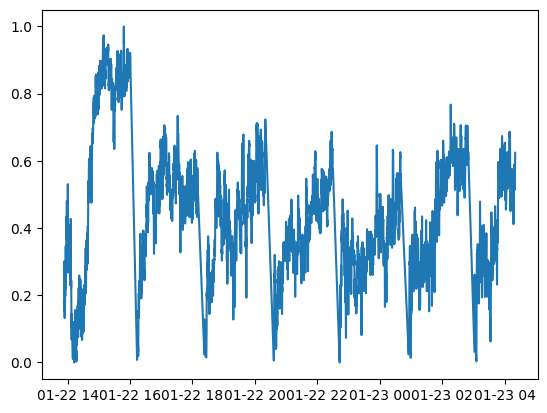

In [16]:
import matplotlib.pyplot as plt

plt.plot(data)

In [17]:
data.to_csv("../data/preprocessed/timeseries.csv")